In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd2
from matplotlib.projections import polar
from tqdm import tqdm
import matplotlib.ticker as ticker
import glob
import os

In [195]:
gamma = 1.4

def Plot(r, theta, Phi):
    fig = plt.figure(figsize=(10, 10))
    R, Theta = np.meshgrid(r, theta)
    ax = fig.add_subplot(111)
    c = ax.pcolormesh(R, Theta, Phi.T, cmap='viridis')
    plt.colorbar(c, ax=ax, label='')
    plt.xlabel('r', fontsize=18)
    plt.ylabel("theta", fontsize=18)
    plt.title("Phi", fontsize=18)
    plt.show()
    
def get_cp(Phi, eta):
    h_eta = eta[1] - eta[0]
    print(h_eta)
    dPhi_deta = (Phi[1, :] - Phi[0, : ]) / (h_eta)
    print(dPhi_deta[250])
    cp = 1 - dPhi_deta**2
    return cp
    
def Plot_cp(cp, eta):    
    plt.plot(eta, cp)
    plt.xlabel('Eta')
    plt.ylabel('cp')
    plt.title('cp')
    plt.show()
    
def get_local_Mach(u, v, p, Mach):
    a2 = 1.4 * p[0, :] **(1.4 - 1)
    M2 = (u[0, :]**2 + v[0, :]**2) / a2
    M = np.sqrt(M2) * Mach
    return M

def uvp(w,r, theta, dr, dtheta,  Mah):
    id, jd = w.shape
    id -= 1
    jd -=1
    cv = np.zeros(id + 1)
    cu = 1/ (2 * dr)
    for i in range(id + 1):
        cv[i] = 0.5 / (r[i] * dtheta)
    u = np.zeros((id + 1, jd + 1))
    v = np.zeros((id + 1, jd + 1))
    p = np.ones((id + 1, jd + 1))
    cMM = Mah * Mah * (gamma + 1) / 2
    for j in range(1, jd):
        for i in range(1, id):
            u[i, j] = (w[i + 1, j] - w[i - 1, j]) * cu
            v[i, j] = (w[i, j + 1] - w[i, j - 1]) * cv[i]
            VV = u[i, j]**2 + v[i, j]**2
            q = (1. - VV) * cMM + 1
            p[i, j] = np.sqrt(q) * q**2
        v[0, j] = v[1, j]
        u[0, j] = u[1, j]
        v[id, j] = v[id - 1, j]
        u[id, j] = u[id -1, j]
        p[0][j] = p[1][j]
        p[id][j] = p[id - 1][j]
    for i in range(1, id - 1):
        u[i, 0] = u[i, 1]
        u[i, jd] = u[i, jd - 1]
        v[i, 0] = v[i, 1]
        v[i, jd] = v[i, jd - 1]
        p[i][0] = p[i][1]
        p[i][jd] = p[i][jd - 1]
    return u, v, p


def find_matching_files(prefix, extension=".txt", folder_path="../results/"):
    search_pattern = os.path.join(folder_path, f"{prefix}_*{extension}")
    matching_files = [
        os.path.splitext(os.path.basename(file))[0]
        for file in glob.glob(search_pattern)
        if "r.txt" not in file and "theta.txt" not in file
    ]
    return matching_files

def plot_polar_data(data, r, theta, data_name, Mach_number, filename=""):
    R, Theta = np.meshgrid(r, theta)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    c = ax.contourf(R, Theta, data.T, cmap='viridis')
    plt.colorbar(c, label=data_name)
    plt.title(f'График {data_name} в полярных координатах (Mach {Mach_number})')
    ax.set_xlabel('r', fontsize=18)
    ax.set_ylabel(r'$\theta$', fontsize=18)
    if filename:
            plt.savefig(f"{filename}_Mach_{Mach_number}.png")
    plt.show()
    
def find_matching_files(prefix, extension=".txt", folder_path="../results"):
    search_pattern = os.path.join(folder_path, f"{prefix}_*{extension}")
    matching_files = [
        os.path.splitext(os.path.basename(file))[0]
        for file in glob.glob(search_pattern)
        if "r.txt" not in file and "theta.txt" not in file
    ]
    return matching_files    
    
def read_data_from_files(base_file_name):
    filename = "../results/" + base_file_name
    phi_file = f"{filename}.txt"
    r_file = f"{filename}_r.txt"
    theta_file = f"{filename}_theta.txt"

    phi, r, theta = None, None, None
    
    try:
        phi = np.loadtxt(phi_file)
    except Exception as e:
        print(f"Ошибка чтения файла {phi_file}: {e}")
    try:
        r = np.loadtxt(r_file)
    except Exception as e:
        print(f"Ошибка чтения файла {r_file}: {e}")
    try:
        theta = np.loadtxt(theta_file)
    except Exception as e:
        print(f"Ошибка чтения файла {theta_file}: {e}")

    # Извлечение числа Маха из имени файла
    parts = base_file_name.split('_')
    mach_number = float(parts[3]) if len(parts) > 3 else None

    
    dr = r[1] - r[0]
    dtheta = theta[1] - theta[0]
    return phi, r, theta, dr, dtheta, mach_number

def plot_phi_ratio(phi_1, phi_2, Mach_number):
    phi_ratio = phi_1 / phi_2
    plt.figure(figsize=(15, 15))
    img = plt.imshow(phi_ratio, cmap='viridis', origin='lower', extent=[theta[0], theta[-1], r[0], r[-1]], aspect='auto')
    cbar = plt.colorbar(img)
    cbar.set_label(r'Отношение $\frac{{\Phi_{{FEM}}}}{{\Phi_{{chess}}}}$', fontsize=15)
    plt.title(r'Тепловая карта отношения $\frac{{\Phi_{{FEM}}}}{{\Phi_{{chess}}}}$ при $M = {}$'.format(Mach_number), fontsize=20)
    plt.xlabel(r'$\theta$', fontsize=20)
    plt.ylabel('r', fontsize=20)
    plt.savefig("./plots/headmap_{}.png".format(Mach))
    plt.show()


<Figure size 1080x864 with 0 Axes>

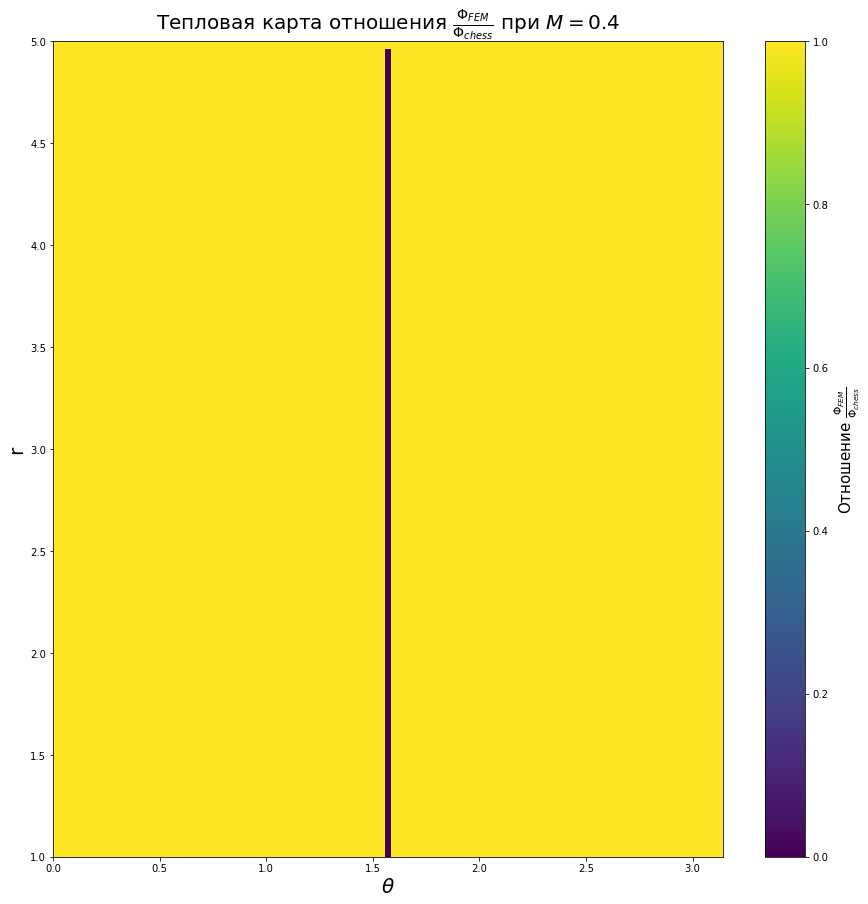

In [202]:
plt.figure(figsize=(15, 12))


phi_1, r, theta, dr, dtheta, Mach = read_data_from_files("chess_100_100_0.400000_3034")
phi_2, r, theta, dr, dtheta, Mach = read_data_from_files("FEM_100_100_0.400000_38834")

plot_phi_ratio(phi_1, phi_2, Mach)

<Figure size 1080x864 with 0 Axes>

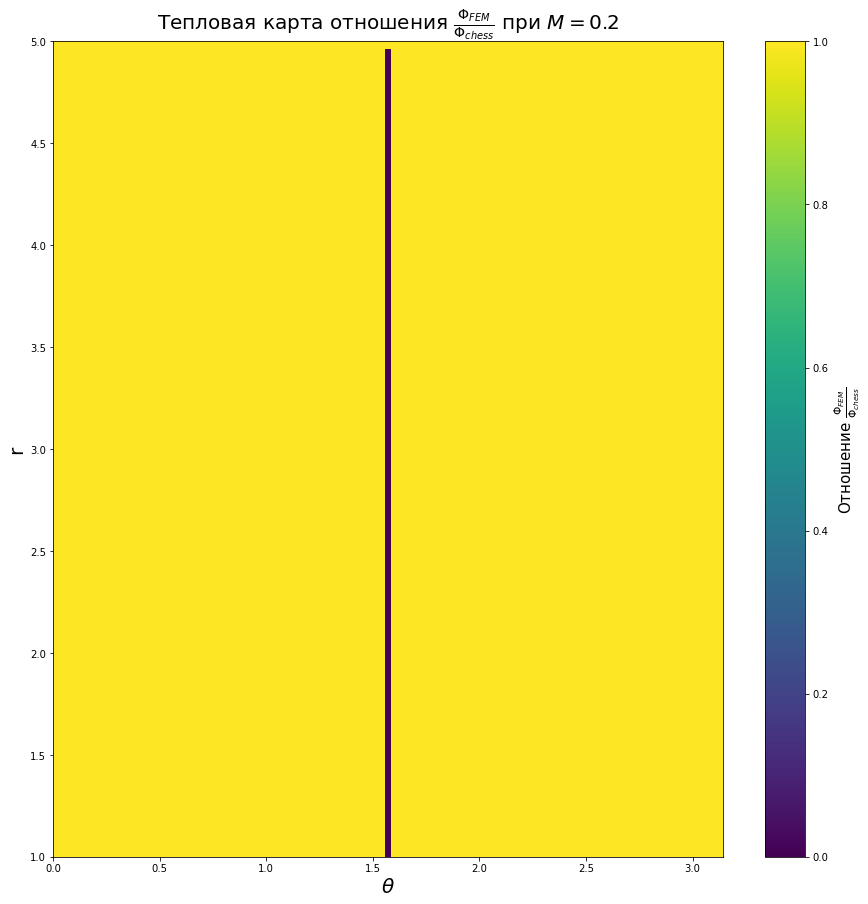

In [199]:
plt.figure(figsize=(15, 12))


phi_1, r, theta, dr, dtheta, Mach = read_data_from_files("chess_100_100_0.200000_2628")
phi_2, r, theta, dr, dtheta, Mach = read_data_from_files("FEM_100_100_0.200000_37045")

plot_phi_ratio(phi_1, phi_2, Mach)


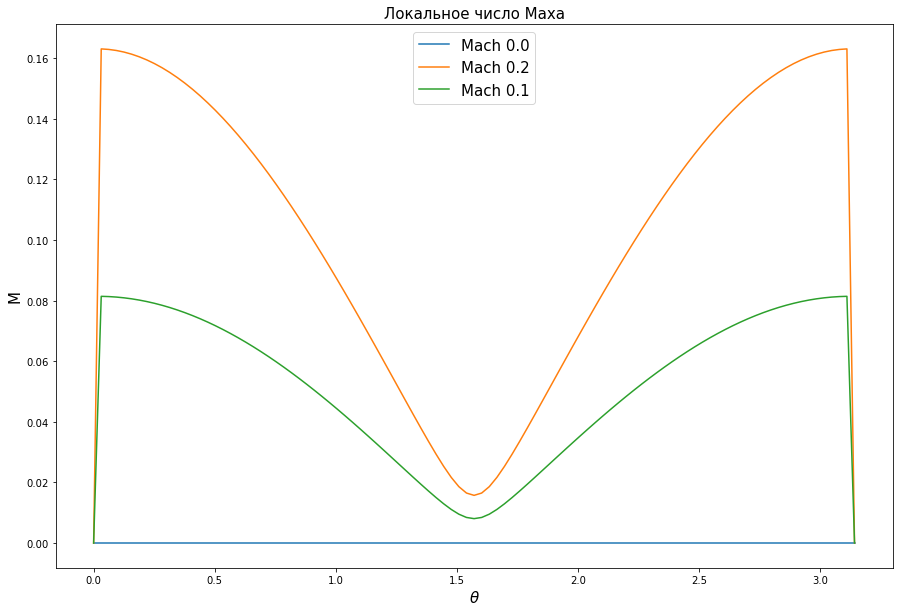

In [221]:
method = "sweep"
files = find_matching_files(method)
png_path = "./plots/" + method + "_"

files = find_matching_files(method)


plt.figure(figsize=(15, 10))

for path in files:
    phi, r, theta, dr, dtheta, Mach = read_data_from_files(path)
    u, v, p = uvp(phi, r, theta, dr, dtheta, Mach)
    M = get_local_Mach(u, v, p, Mach)
    plt.plot(theta, get_local_Mach(u, v, p, Mach), label = "Mach {}".format(Mach))    
    
plt.legend(fontsize = 15)
plt.title("Локальное число Маха", fontsize = 15)
plt.xlabel(r"$\theta$", fontsize=15)
plt.ylabel(r"M", fontsize=15)
plt.savefig(png_path  +"_local_Mach.png")
plt.show()    


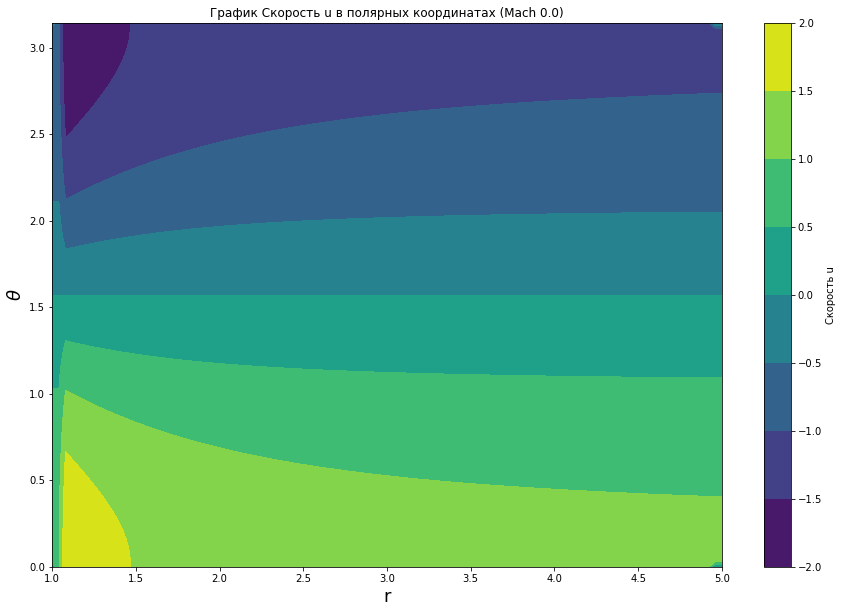

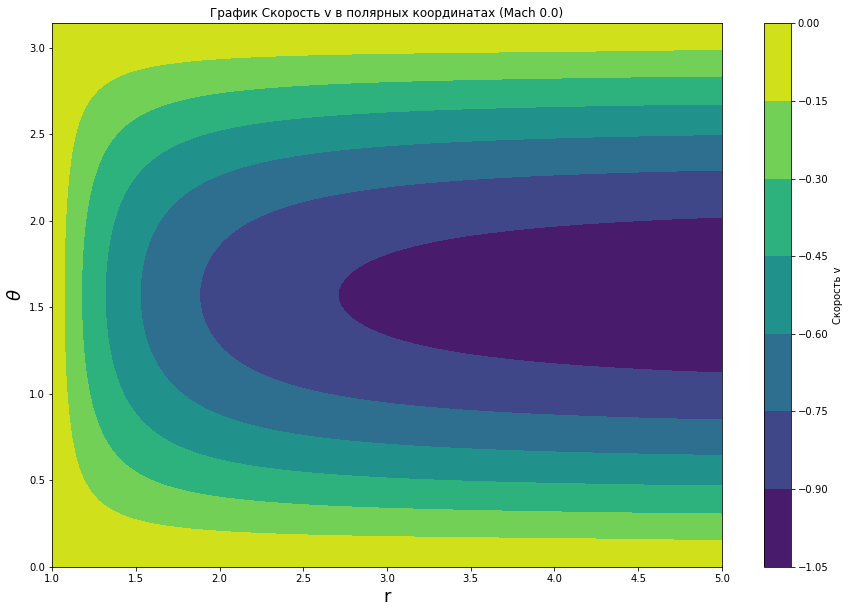

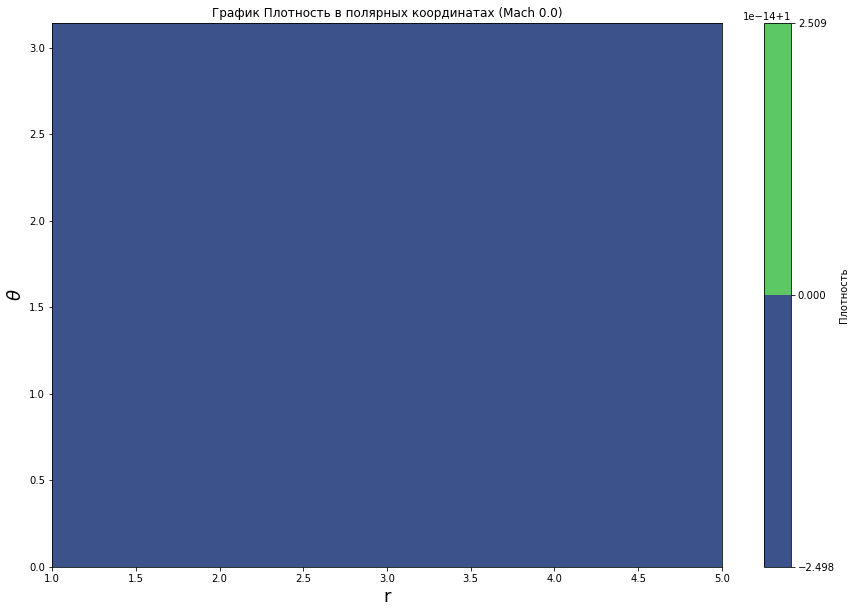

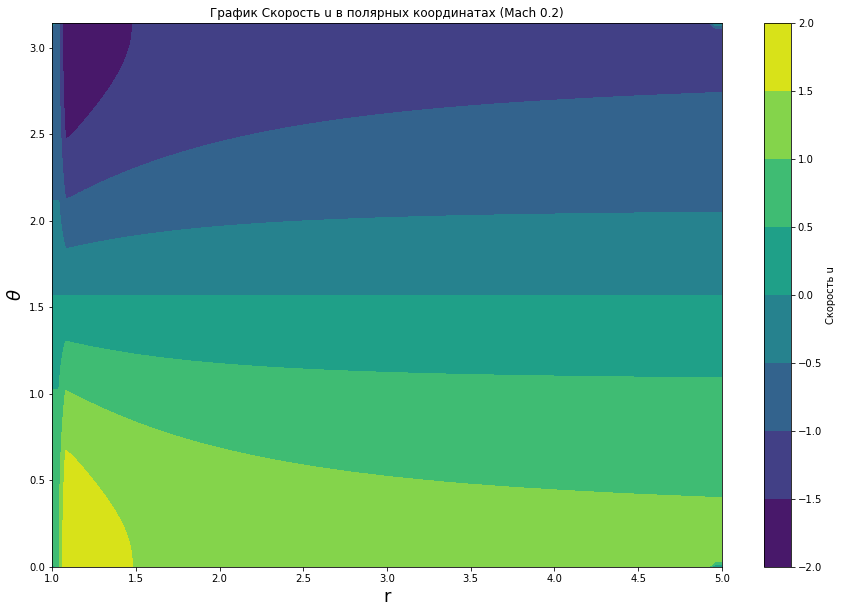

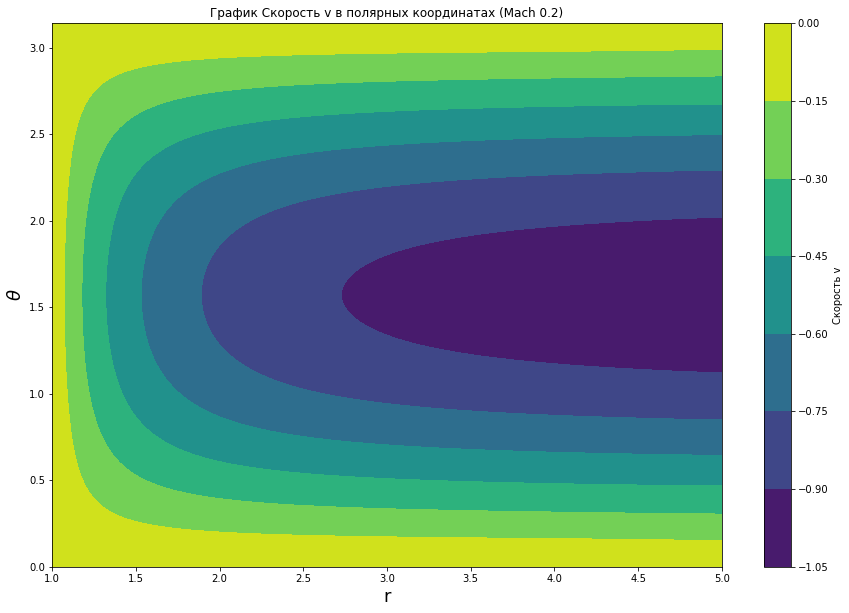

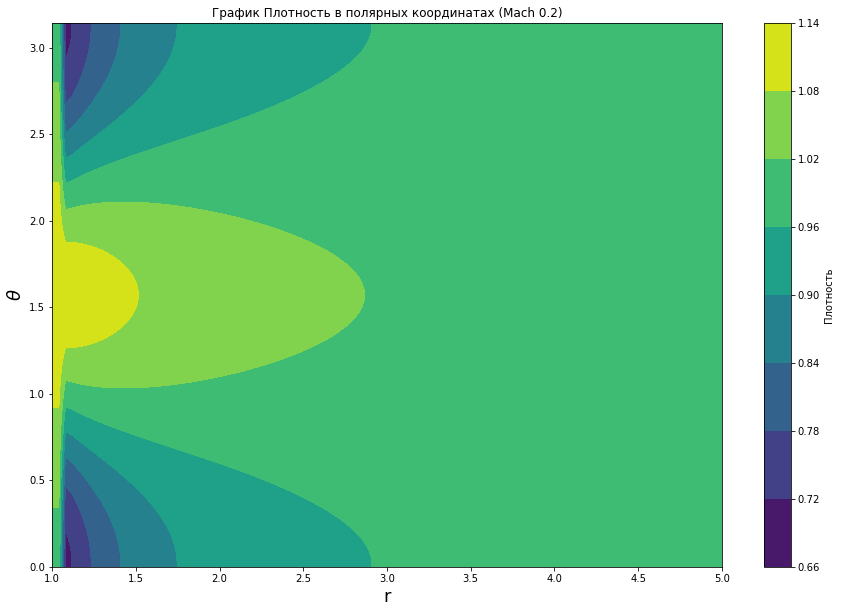

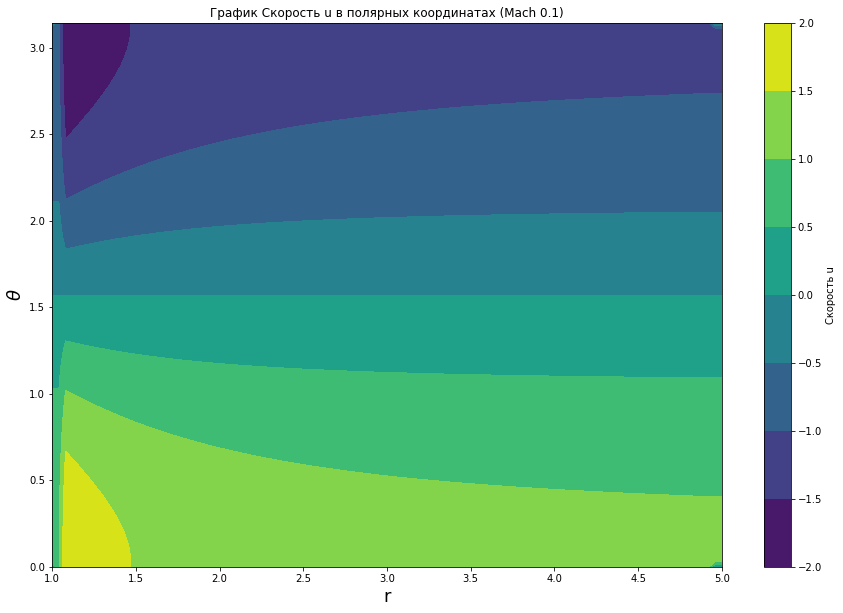

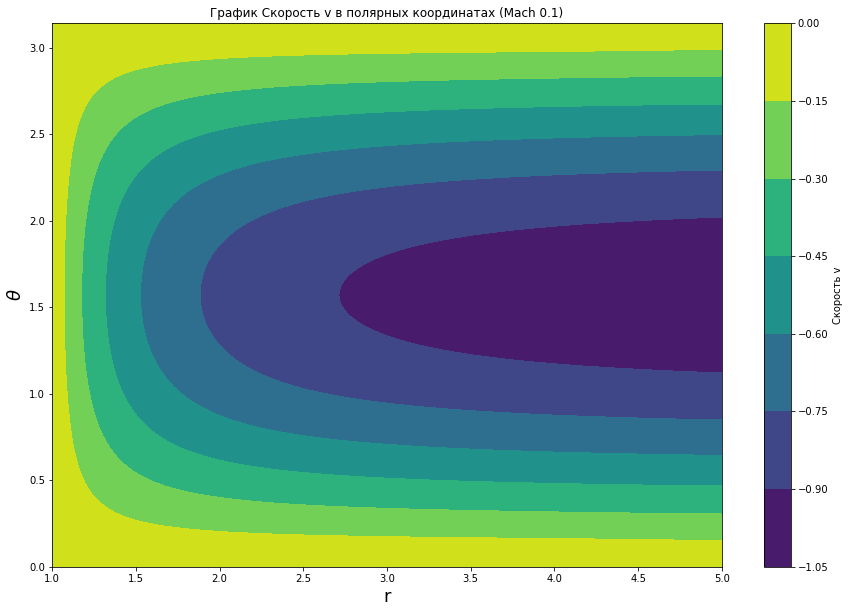

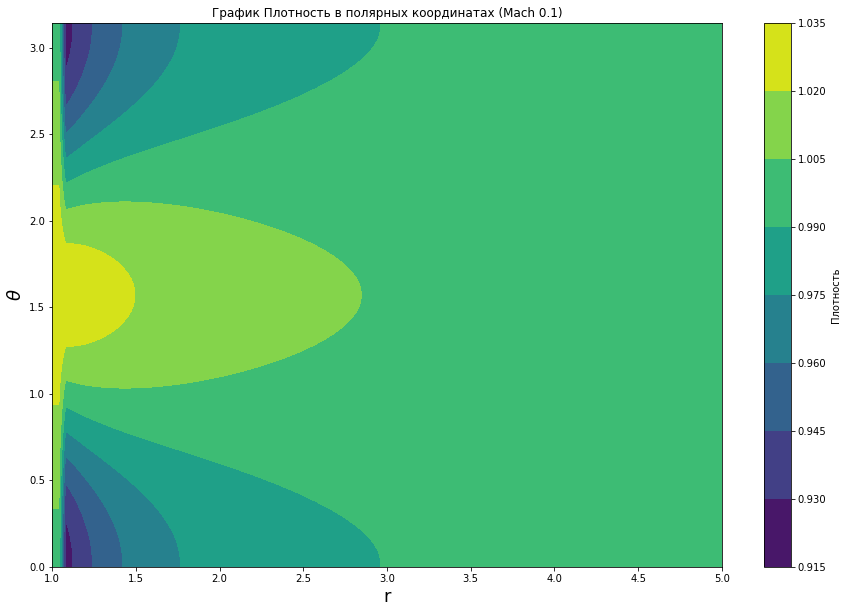

In [222]:
method = "sweep"
files = find_matching_files(method)

for file_path in files:
    phi, r, theta, dr, dtheta, Mach = read_data_from_files(file_path)
    u, v, p = uvp(phi, r, theta, dr, dtheta, Mach)
    png_path = "./plots/" + method + "_"
    plot_polar_data(u, r, theta, 'Скорость u', Mach_number=Mach, filename=png_path + 'u_graph')
    plot_polar_data(v, r, theta, 'Скорость v', Mach_number=Mach, filename=png_path + 'v_graph')
    plot_polar_data(p, r, theta, 'Плотность', Mach_number=Mach, filename=png_path + 'p_graph')

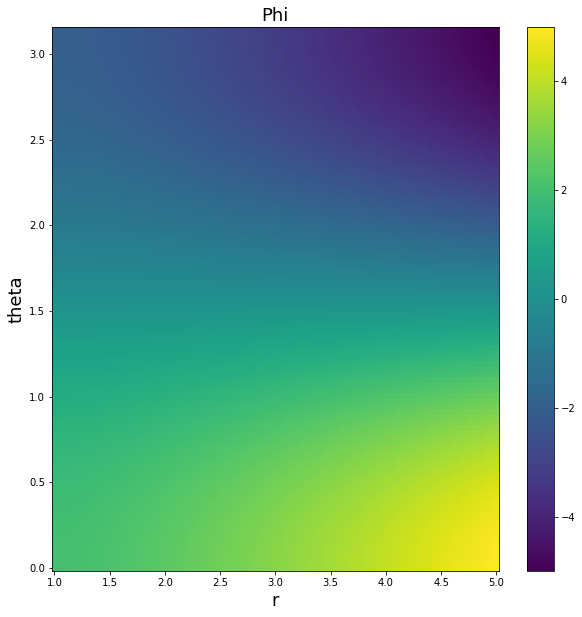

In [42]:
plot_u(u, r, theta)

NameError: name 'plot_u' is not defined

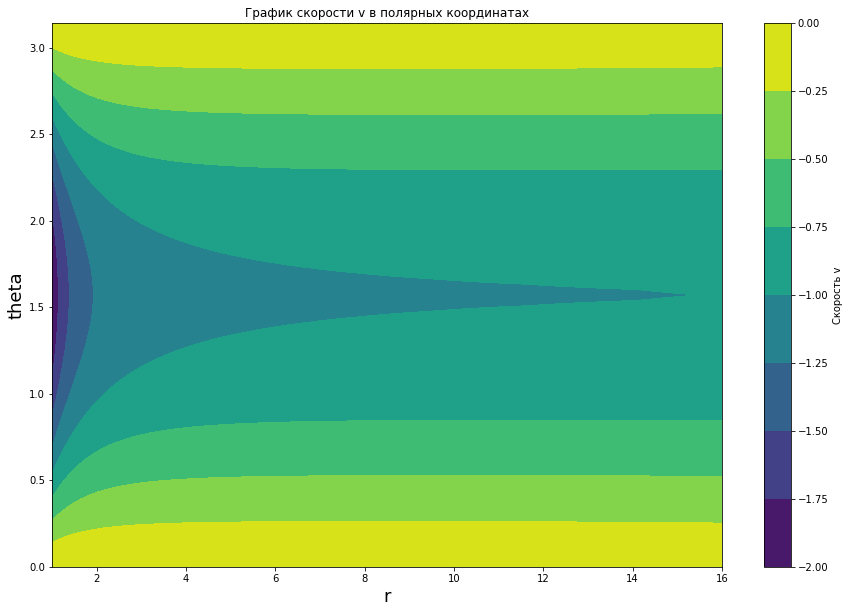

In [177]:
plot_v(v, r, theta)

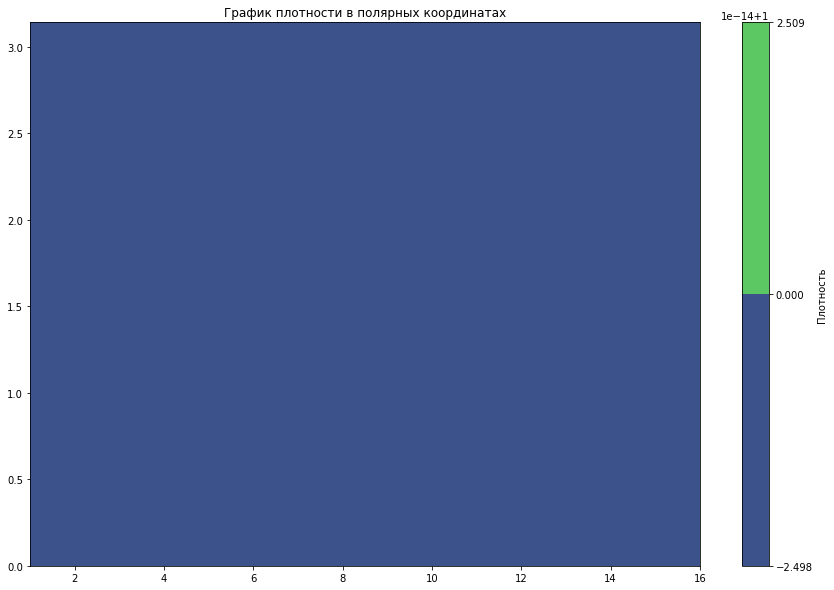

In [178]:
plot_p(p, r, theta)

In [ ]:
M0 = 

In [9]:
phi, r, theta, dr, dtheta, Mach = read_data(file_path)

In [13]:
u, v, p = uvp(phi, r, theta, dr, dtheta, Mach)

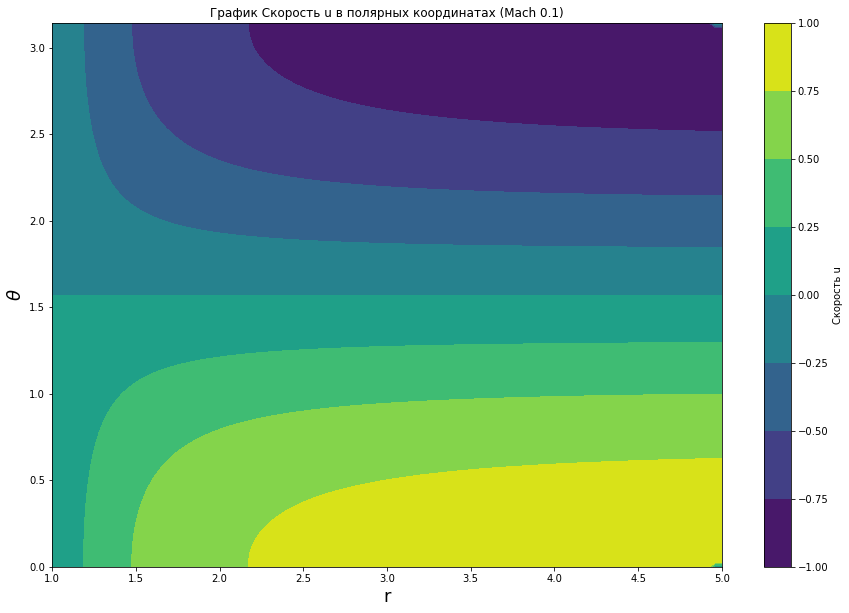

In [14]:
plot_polar_data(u, r, theta, 'Скорость u', Mach_number=Mach, filename='u_graph')

In [114]:
M1 = get_local_Mach(u, v, p, Mach)

In [151]:
len(r)

101

In [105]:
M2 = get_local_Mach(u, v, p, Mach)

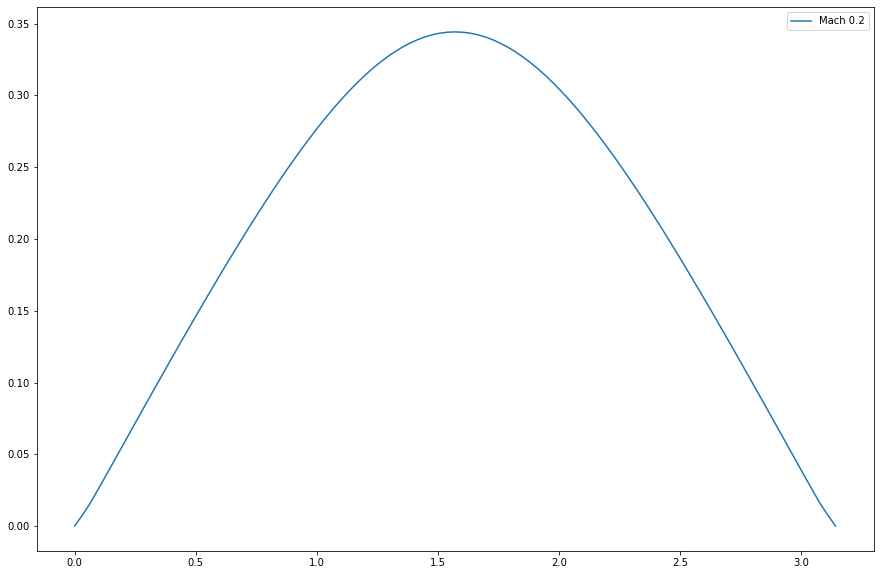

In [93]:
plt.figure(figsize=(15, 10))

plt.plot(theta, get_local_Mach(u, v, p, Mach), label = "Mach {}".format(Mach))
plt.legend()
plt.show()

In [95]:
add_Mach_line(ax, theta, u, v, p, Mach)

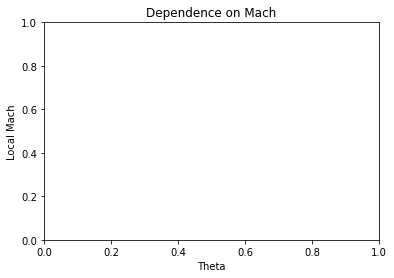

In [96]:
plt.xlabel('Theta')
plt.ylabel('Local Mach')
plt.title('Dependence on Mach')
plt.show()

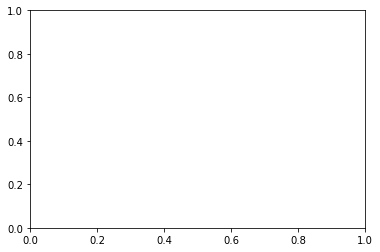

In [94]:
fig, ax = plt.subplots()

In [92]:
plt.figure(figsize=(15, 10))

def add_Mach_line(ax, theta, u, v, p, Mach):
    ax.plot(theta, get_local_Mach(u, v, p, Mach), label="Mach {}".format(Mach))
    ax.legend()

<Figure size 1080x720 with 0 Axes>

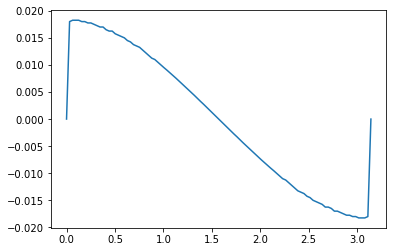

In [328]:
plt.plot(theta, u[0])